# Imports

In [5]:
# Import Modules
import os
import pandas as pd
import numpy as np
from itertools import chain
import cv2
import split_folders

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report

# Deep Learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

2.0.0


# The dataset

The dataset used for training are **100,000 HE image tiles** from 86 Colorectal Cancer tissue slides. The images are classified into **9** different tissue types: **ADI** (adipose tissue), **BACK** (background), **DEB** (debris), **LYM** (lymphocytes), **MUC** (mucus), **MUS** (smooth muscle), **NORM** (normal colon mucosa), **STR** (cancer-associated stroma), and **TUM** (colorectal adenocarcinoma epithelium) and are organized in 9 different folders.

In [5]:
base_dir = "/floyd/input/colorectal_cancer"
input_ = os.path.join(base_dir,"NCT-CRC-HE-100K")

# split data into training, vlaidation and testing sets
split_folders.ratio(input_, 'output', seed = 101, ratio=(0.8, 0.1, 0.1))

data_dir = os.path.join('/floyd/home','output')

# Define train, valid and test directories
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [6]:
os.listdir('output')

['val', 'test', 'train']

# Data Augmentation and EDA

Data augmentation is a strategy that adds noise and increase the diversity of the training data. It is a form of regularization and generalizes tbe model.  

The method purposely perturbs training examples, changing their appearance slightly, before passing them into the network for training. This partially alleviates the need to gather more training data.

Initialize each of our generators with data augmentation techniques such as horizontal flipping, vertical flipping, shear, rotation and shift are commonly used to train large neural networks.

In [9]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [2]:
# Train ImageDataGenerator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=64,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                batch_size=1,
                                                target_size=(224,224),
                                                class_mode='categorical',
                                                shuffle=False,
                                                seed=42,
                                                color_mode='rgb')

# Resent50

## Training cycle #1

In [44]:
base_model_resnet50 = ResNet50(input_shape=(224,224,3),
                               include_top=False, 
                               weights='imagenet')

x = base_model_resnet50.output
flat = Flatten()(x)
hidden_1 = Dense(1024, activation='relu')(flat)
drop_1 = Dropout(0.2)(hidden_1)
hidden_2 = Dense(512, activation='relu')(drop_1)
drop_2 = Dropout(0.3)(hidden_2)
output = Dense(9, activation= 'softmax')(drop_2)

model_resnet50_01 = Model(base_model_resnet50.inputs, output)

# Call Backs
filepath = 'resent50_base_model_wt.h5'
es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', period=1)
# compile the model
model_resnet50_01.compile(loss="categorical_crossentropy", optimizer=Adam(lr = 0.0004), metrics=["accuracy"])

94658560/94653016 [==============================] - 5s 0us/step


In [15]:
resnet50_history_01 = model_resnet50_01.fit_generator(train_generator,
                                                      steps_per_epoch=225,
                                                      epochs=10,
                                                      callbacks = [es, cp],
                                                      validation_data = valid_generator)

Epoch 1/10
224/225 [============================>.] - ETA: 1s - loss: 0.3051 - acc: 0.9086
Epoch 00001: val_loss improved from inf to 12.74186, saving model to resent50_base_model_wt.h5
225/225 [==============================] - 306s 1s/step - loss: 0.3040 - acc: 0.9090 - val_loss: 12.7419 - val_acc: 0.1057
Epoch 2/10
224/225 [============================>.] - ETA: 0s - loss: 0.1916 - acc: 0.9455
Epoch 00002: val_loss improved from 12.74186 to 2.78203, saving model to resent50_base_model_wt.h5
225/225 [==============================] - 233s 1s/step - loss: 0.1928 - acc: 0.9453 - val_loss: 2.7820 - val_acc: 0.0700
Epoch 3/10
224/225 [============================>.] - ETA: 0s - loss: 0.1593 - acc: 0.9515
Epoch 00003: val_loss did not improve from 2.78203
225/225 [==============================] - 225s 999ms/step - loss: 0.1591 - acc: 0.9515 - val_loss: 6.9234 - val_acc: 0.1059
Epoch 4/10
224/225 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9609
Epoch 00004: val_loss

In [16]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_resnet50_01.save_weights(filepath='resent50_base_model_wt.h5', overwrite=True)

### ResNet50 Model Evaluation - training cycle #1

In [46]:
# Load the saved model
model_resnet50_01.load_weights('resent50_base_model_wt.h5')
# Evaluate the model on the hold out validation and test datasets

res_val_eval_01 = model_resnet50_01.evaluate_generator(valid_generator)
res_test_eval_01 = model_resnet50_01.evaluate_generator(test_generator)

print('Validation loss:      {}'.format(res_val_eval_01[0]))
print('Validation accuracy:  {}'.format(res_val_eval_01[1]))
print('Test loss:            {}'.format(res_test_eval_01[0]))
print('Test accuracy:        {}'.format(res_test_eval_01[1]))

# Predict probabilities
res_predictions_01 = model_resnet50_01.predict_generator(test_generator,steps = nb_samples,verbose=1)
# Predict labels
res_pred_labels_01 = np.argmax(res_predictions_01, axis=1)

# Classification Report
print('|'+'-'*67+'|')
print('|-------Classification Report: ReseNet50 Training Cycle #1----------|')
print('|'+'-'*67+'|')
print(classification_report(test_generator.classes, res_pred_labels_01, 
                            target_names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']))


Validation loss:      0.26282002315290454
Validation accuracy:  0.9173586793694871
Test loss:            0.2695801589933224
Test accuracy:        0.9166916391968835
10011/10011 [==============================] - 260s 26ms/step
|-------------------------------------------------------------------|
|-------Classification Report: ReseNet50 Training Cycle #1----------|
|-------------------------------------------------------------------|
              precision    recall  f1-score   support

         ADI       0.97      1.00      0.99      1042
        BACK       0.99      0.99      0.99      1058
         DEB       0.99      0.94      0.97      1152
         LYM       1.00      0.80      0.89      1157
         MUC       0.87      0.97      0.92       891
         MUS       0.79      0.99      0.88      1355
        NORM       0.77      0.85      0.81       877
         STR       0.97      0.71      0.82      1046
         TUM       0.96      0.97      0.96      1433

   micro avg       0.

## Fine tuning ResNet50 model - training cycle #2

In [47]:
base_model_resnet50_02 = ResNet50(input_shape=(224, 224, 3),
                                               include_top = False)
x = base_model_resnet50_02.output
flat = Flatten()(x)
hidden_1 = Dense(1024, activation='relu')(flat)
drop_1 = Dropout(0.2)(hidden_1)
hidden_2 = Dense(512, activation='relu')(drop_1)
drop_2 = Dropout(0.3)(hidden_2)
output = Dense(9, activation= 'softmax')(drop_2)

model_resnet50_02 = Model(base_model_resnet50_02.inputs, output)
model_resnet50_02.load_weights('resent50_base_model_wt.h5')

for layer in model_resnet50_02.layers[:160]:
    layer.trainable= False
    
# Call Backs
filepath_02 = 'resent50_model_02_wt.h5'
es_02 = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp_02 = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', period=1)

model_resnet50_02.compile(loss="categorical_crossentropy", optimizer=Adam(lr = 0.0004), metrics=["accuracy"])

In [23]:
resnet50_history_02 = model_resnet50_02.fit_generator(train_generator,
                                                      steps_per_epoch=225,
                                                      epochs=10,
                                                      callbacks = [es_02, cp_02],
                                                      validation_data = valid_generator)

Epoch 1/10
224/225 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9798
Epoch 00001: val_loss improved from inf to 0.37046, saving model to resent50_base_model_wt.h5
225/225 [==============================] - 207s 921ms/step - loss: 0.0648 - acc: 0.9798 - val_loss: 0.3705 - val_acc: 0.8981
Epoch 2/10
224/225 [============================>.] - ETA: 0s - loss: 0.0795 - acc: 0.9773
Epoch 00002: val_loss did not improve from 0.37046
225/225 [==============================] - 178s 792ms/step - loss: 0.0795 - acc: 0.9772 - val_loss: 0.3741 - val_acc: 0.9054
Epoch 3/10
224/225 [============================>.] - ETA: 0s - loss: 0.0618 - acc: 0.9812
Epoch 00003: val_loss improved from 0.37046 to 0.34197, saving model to resent50_base_model_wt.h5
225/225 [==============================] - 178s 792ms/step - loss: 0.0617 - acc: 0.9812 - val_loss: 0.3420 - val_acc: 0.9086
Epoch 4/10
224/225 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9827
Epoch 00004: val_l

In [25]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_resnet50_02.save_weights(filepath='resent50_model_02_wt.h5', overwrite=True)

### Model Evaluation - training cycle #2

In [48]:
# Load the saved model
model_resnet50_02.load_weights('resent50_model_02_wt.h5')
# Evaluate the model on the hold out validation and test datasets

res_val_eval_02 = model_resnet50_02.evaluate_generator(valid_generator)
res_test_eval_02 = model_resnet50_02.evaluate_generator(test_generator)

print('Validation loss:     {}'.format(res_val_eval_02[0]))
print('Validation accuracy: {}'.format(res_val_eval_02[1]))
print('Test loss:           {}'.format(res_test_eval_02[0]))
print('Test accuracy:       {}'.format(res_test_eval_02[1]))
print('*'*75)

# Predict probabilities
res_predictions_02 = model_resnet50_02.predict_generator(test_generator, steps = nb_samples,verbose=1)
# Predict labels
res_pred_labels_02 = np.argmax(res_predictions_02, axis=1)

# Classification Report
print('|'+'-'*67+'|')
print('|-------Classification Report: ReseNet50 Training Cycle #2----------|')
print('|'+'-'*67+'|')
print(classification_report(test_generator.classes, res_pred_labels_02, 
                            target_names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']))


Validation loss:     0.408025208316844
Validation accuracy: 0.8932466233414731
Test loss:           0.413023896998032
Test accuracy:       0.8924183398261912
***************************************************************************
10011/10011 [==============================] - 262s 26ms/step
|-------------------------------------------------------------------|
|-------Classification Report: ReseNet50 Training Cycle #2----------|
|-------------------------------------------------------------------|
              precision    recall  f1-score   support

         ADI       1.00      0.97      0.98      1042
        BACK       0.99      0.95      0.97      1058
         DEB       0.99      0.78      0.87      1152
         LYM       1.00      0.73      0.84      1157
         MUC       0.86      0.99      0.92       891
         MUS       0.79      0.99      0.88      1355
        NORM       0.70      0.97      0.81       877
         STR       0.85      0.73      0.79      1046
       

## Fine tuning model # Round 3

In [49]:
base_model_resnet50_03 = ResNet50(input_shape=(224, 224, 3),
                                               include_top = False)
x = base_model_resnet50_03.output
flat = Flatten()(x)
hidden_1 = Dense(1024, activation='relu')(flat)
drop_1 = Dropout(0.2)(hidden_1)
hidden_2 = Dense(512, activation='relu')(drop_1)
drop_2 = Dropout(0.3)(hidden_2)
output = Dense(9, activation= 'softmax')(drop_2)

model_resnet50_03 = Model(base_model_resnet50_03.inputs, output)
model_resnet50_03.load_weights('resent50_model_02_wt.h5')

for layer in model_resnet50_03.layers[:118]:
    layer.trainable= False
    
# Call Backs
filepath_03 = 'resent50_model_03_wt.h5'
es_03 = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp_03 = ModelCheckpoint(filepath_03, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', period=1)

model_resnet50_03.compile(loss="categorical_crossentropy", optimizer=Adam(lr = 0.0004), metrics=["accuracy"])


In [30]:
resnet50_history_03 = model_resnet50_03.fit_generator(train_generator,
                                                      steps_per_epoch=225,
                                                      epochs=10,
                                                      callbacks = [es_02, cp_02],
                                                      validation_data = valid_generator)

Epoch 1/10
224/225 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9754
Epoch 00001: val_loss did not improve from 0.33921
225/225 [==============================] - 191s 848ms/step - loss: 0.0835 - acc: 0.9755 - val_loss: 0.9691 - val_acc: 0.8447
Epoch 2/10
224/225 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9794
Epoch 00002: val_loss improved from 0.33921 to 0.22405, saving model to resent50_base_model_wt.h5
225/225 [==============================] - 206s 917ms/step - loss: 0.0653 - acc: 0.9794 - val_loss: 0.2241 - val_acc: 0.9347
Epoch 3/10
224/225 [============================>.] - ETA: 0s - loss: 0.0669 - acc: 0.9796
Epoch 00003: val_loss did not improve from 0.22405
225/225 [==============================] - 176s 781ms/step - loss: 0.0667 - acc: 0.9797 - val_loss: 0.4240 - val_acc: 0.8938
Epoch 4/10
224/225 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9834
Epoch 00004: val_loss did not improve from 0.22405
225/225 [=

In [ ]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_resnet50_03.save_weights(filepath='resent50_model_03_wt.h5', overwrite=True)


### ResNet50 Model Evaluation - training cyle #3

In [50]:
# Load the saved model
model_resnet50_03.load_weights('resent50_model_03_wt.h5')
# Evaluate the model on the hold out validation and test datasets

res_val_eval_03 = model_resnet50_03.evaluate_generator(valid_generator)
res_test_eval_03 = model_resnet50_03.evaluate_generator(test_generator)

print('Validation loss:     {0:.3f}'.format(res_val_eval_03[0]))
print('Validation accuracy: {0:.3f}'.format(res_val_eval_03[1]))
print('Test loss:           {0:.3f}'.format(res_test_eval_03[0]))
print('Test accuracy:       {0:.3f}'.format(res_test_eval_03[1]))

# Predict probabilities
res_predictions_03 = model_resnet50_03.predict_generator(test_generator,steps = nb_samples,verbose=1)
# Predict labels
res_pred_labels_03 = np.argmax(res_predictions_03, axis=1)

# Classification Report
print('|'+'-'*67+'|')
print('|-------Classification Report: ReseNet50 Training Cycle #3----------|')
print('|'+'-'*67+'|')
print(classification_report(test_generator.classes, res_pred_labels_03, 
                            target_names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']))


Validation loss:     0.371
Validation accuracy: 0.908
Test loss:           0.380
Test accuracy:       0.908
10011/10011 [==============================] - 269s 27ms/step
|-------------------------------------------------------------------|
|-------Classification Report: ReseNet50 Training Cycle #3----------|
|-------------------------------------------------------------------|
              precision    recall  f1-score   support

         ADI       1.00      0.97      0.99      1042
        BACK       0.99      0.95      0.97      1058
         DEB       1.00      0.91      0.95      1152
         LYM       1.00      0.83      0.91      1157
         MUC       0.90      0.97      0.93       891
         MUS       0.82      1.00      0.90      1355
        NORM       0.66      0.99      0.79       877
         STR       0.95      0.70      0.81      1046
         TUM       0.98      0.86      0.92      1433

   micro avg       0.91      0.91      0.91     10011
   macro avg       0.92 

## Fine tuning Resnet50 model training cycle #4

In [51]:
base_model_resnet50_04 = ResNet50(input_shape=(224, 224, 3),
                                               include_top = False)
x = base_model_resnet50_04.output
flat = Flatten()(x)
hidden_1 = Dense(1024, activation='relu')(flat)
drop_1 = Dropout(0.2)(hidden_1)
hidden_2 = Dense(512, activation='relu')(drop_1)
drop_2 = Dropout(0.3)(hidden_2)
output = Dense(9, activation= 'softmax')(drop_2)

model_resnet50_04 = Model(base_model_resnet50_04.inputs, output)
model_resnet50_04.load_weights('resent50_model_03_wt.h5')

# Call Backs
filepath_04 = 'resent50_model_04_wt.h5'
es_04 = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp_04 = ModelCheckpoint(filepath_04, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', period=1)

model_resnet50_04.compile(loss="categorical_crossentropy", optimizer=Adam(lr = 0.0004), metrics=["accuracy"])


In [35]:
resnet50_history_04 = model_resnet50_04.fit_generator(train_generator,
                                                      steps_per_epoch=225,
                                                      epochs=30,
                                                      callbacks = [es_04, cp_04],
                                                      validation_data = valid_generator)

Epoch 1/30
224/225 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9865
Epoch 00001: val_loss improved from inf to 0.03184, saving model to resent50_model_04_wt.h5
225/225 [==============================] - 239s 1s/step - loss: 0.0432 - acc: 0.9866 - val_loss: 0.0318 - val_acc: 0.9905
Epoch 2/30
224/225 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9866
Epoch 00002: val_loss improved from 0.03184 to 0.02968, saving model to resent50_model_04_wt.h5
225/225 [==============================] - 180s 800ms/step - loss: 0.0433 - acc: 0.9867 - val_loss: 0.0297 - val_acc: 0.9910
Epoch 3/30
224/225 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9865
Epoch 00003: val_loss improved from 0.02968 to 0.02908, saving model to resent50_model_04_wt.h5
225/225 [==============================] - 180s 799ms/step - loss: 0.0433 - acc: 0.9865 - val_loss: 0.0291 - val_acc: 0.9909
Epoch 4/30
224/225 [============================>.] - ETA: 0s - loss: 0

In [ ]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_resnet50_04.save_weights(filepath='model_weights/resent50_model_04_wt.h5', overwrite=True)


In [52]:
# Load the saved model
model_resnet50_04.load_weights('resent50_model_04_wt.h5')
# Evaluate the model on the hold out validation and test datasets

res_val_eval_04 = model_resnet50_04.evaluate_generator(valid_generator)
res_test_eval_04 = model_resnet50_04.evaluate_generator(test_generator)

print('Validation loss:     {}'.format(res_val_eval_04[0]))
print('Validation accuracy: {}'.format(res_val_eval_04[1]))
print('Test loss:           {}'.format(res_test_eval_04[0]))
print('Test accuracy:       {}'.format(res_test_eval_04[1]))


res_predictions_04 = model_resnet50_04.predict_generator(test_generator,
                                                         steps = nb_samples,
                                                         verbose=1)
res_pred_labels_04 = np.argmax(res_predictions_04, axis=1)

# Classification Report
print('|'+'-'*67+'|')
print('|-------Classification Report: ReseNet50 Training Cycle #4----------|')
print('|'+'-'*67+'|')
print(classification_report(test_generator.classes, res_pred_labels_04, 
                            target_names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']))


Validation loss:     0.02831684008623665
Validation accuracy: 0.9906953476738369
Test loss:           0.027173774265380042
Test accuracy:       0.9926081310558386
10011/10011 [==============================] - 267s 27ms/step
|-------------------------------------------------------------------|
|-------Classification Report: ReseNet50 Training Cycle #4----------|
|-------------------------------------------------------------------|
              precision    recall  f1-score   support

         ADI       1.00      1.00      1.00      1042
        BACK       1.00      1.00      1.00      1058
         DEB       0.98      0.99      0.99      1152
         LYM       1.00      1.00      1.00      1157
         MUC       0.99      0.99      0.99       891
         MUS       0.99      0.99      0.99      1355
        NORM       0.99      0.99      0.99       877
         STR       0.99      0.98      0.98      1046
         TUM       0.99      0.99      0.99      1433

   micro avg       0.99

In [53]:
# Confusion Matrices
res_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, res_pred_labels_01), 
                        index=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                        columns=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])



res_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, res_pred_labels_02), 
                        index=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                        columns=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])

res_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, res_pred_labels_03), 
                        index=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                        columns=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])

res_conf_mat_04 = pd.DataFrame(confusion_matrix(test_generator.classes, res_pred_labels_04), 
                        index=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                        columns=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])


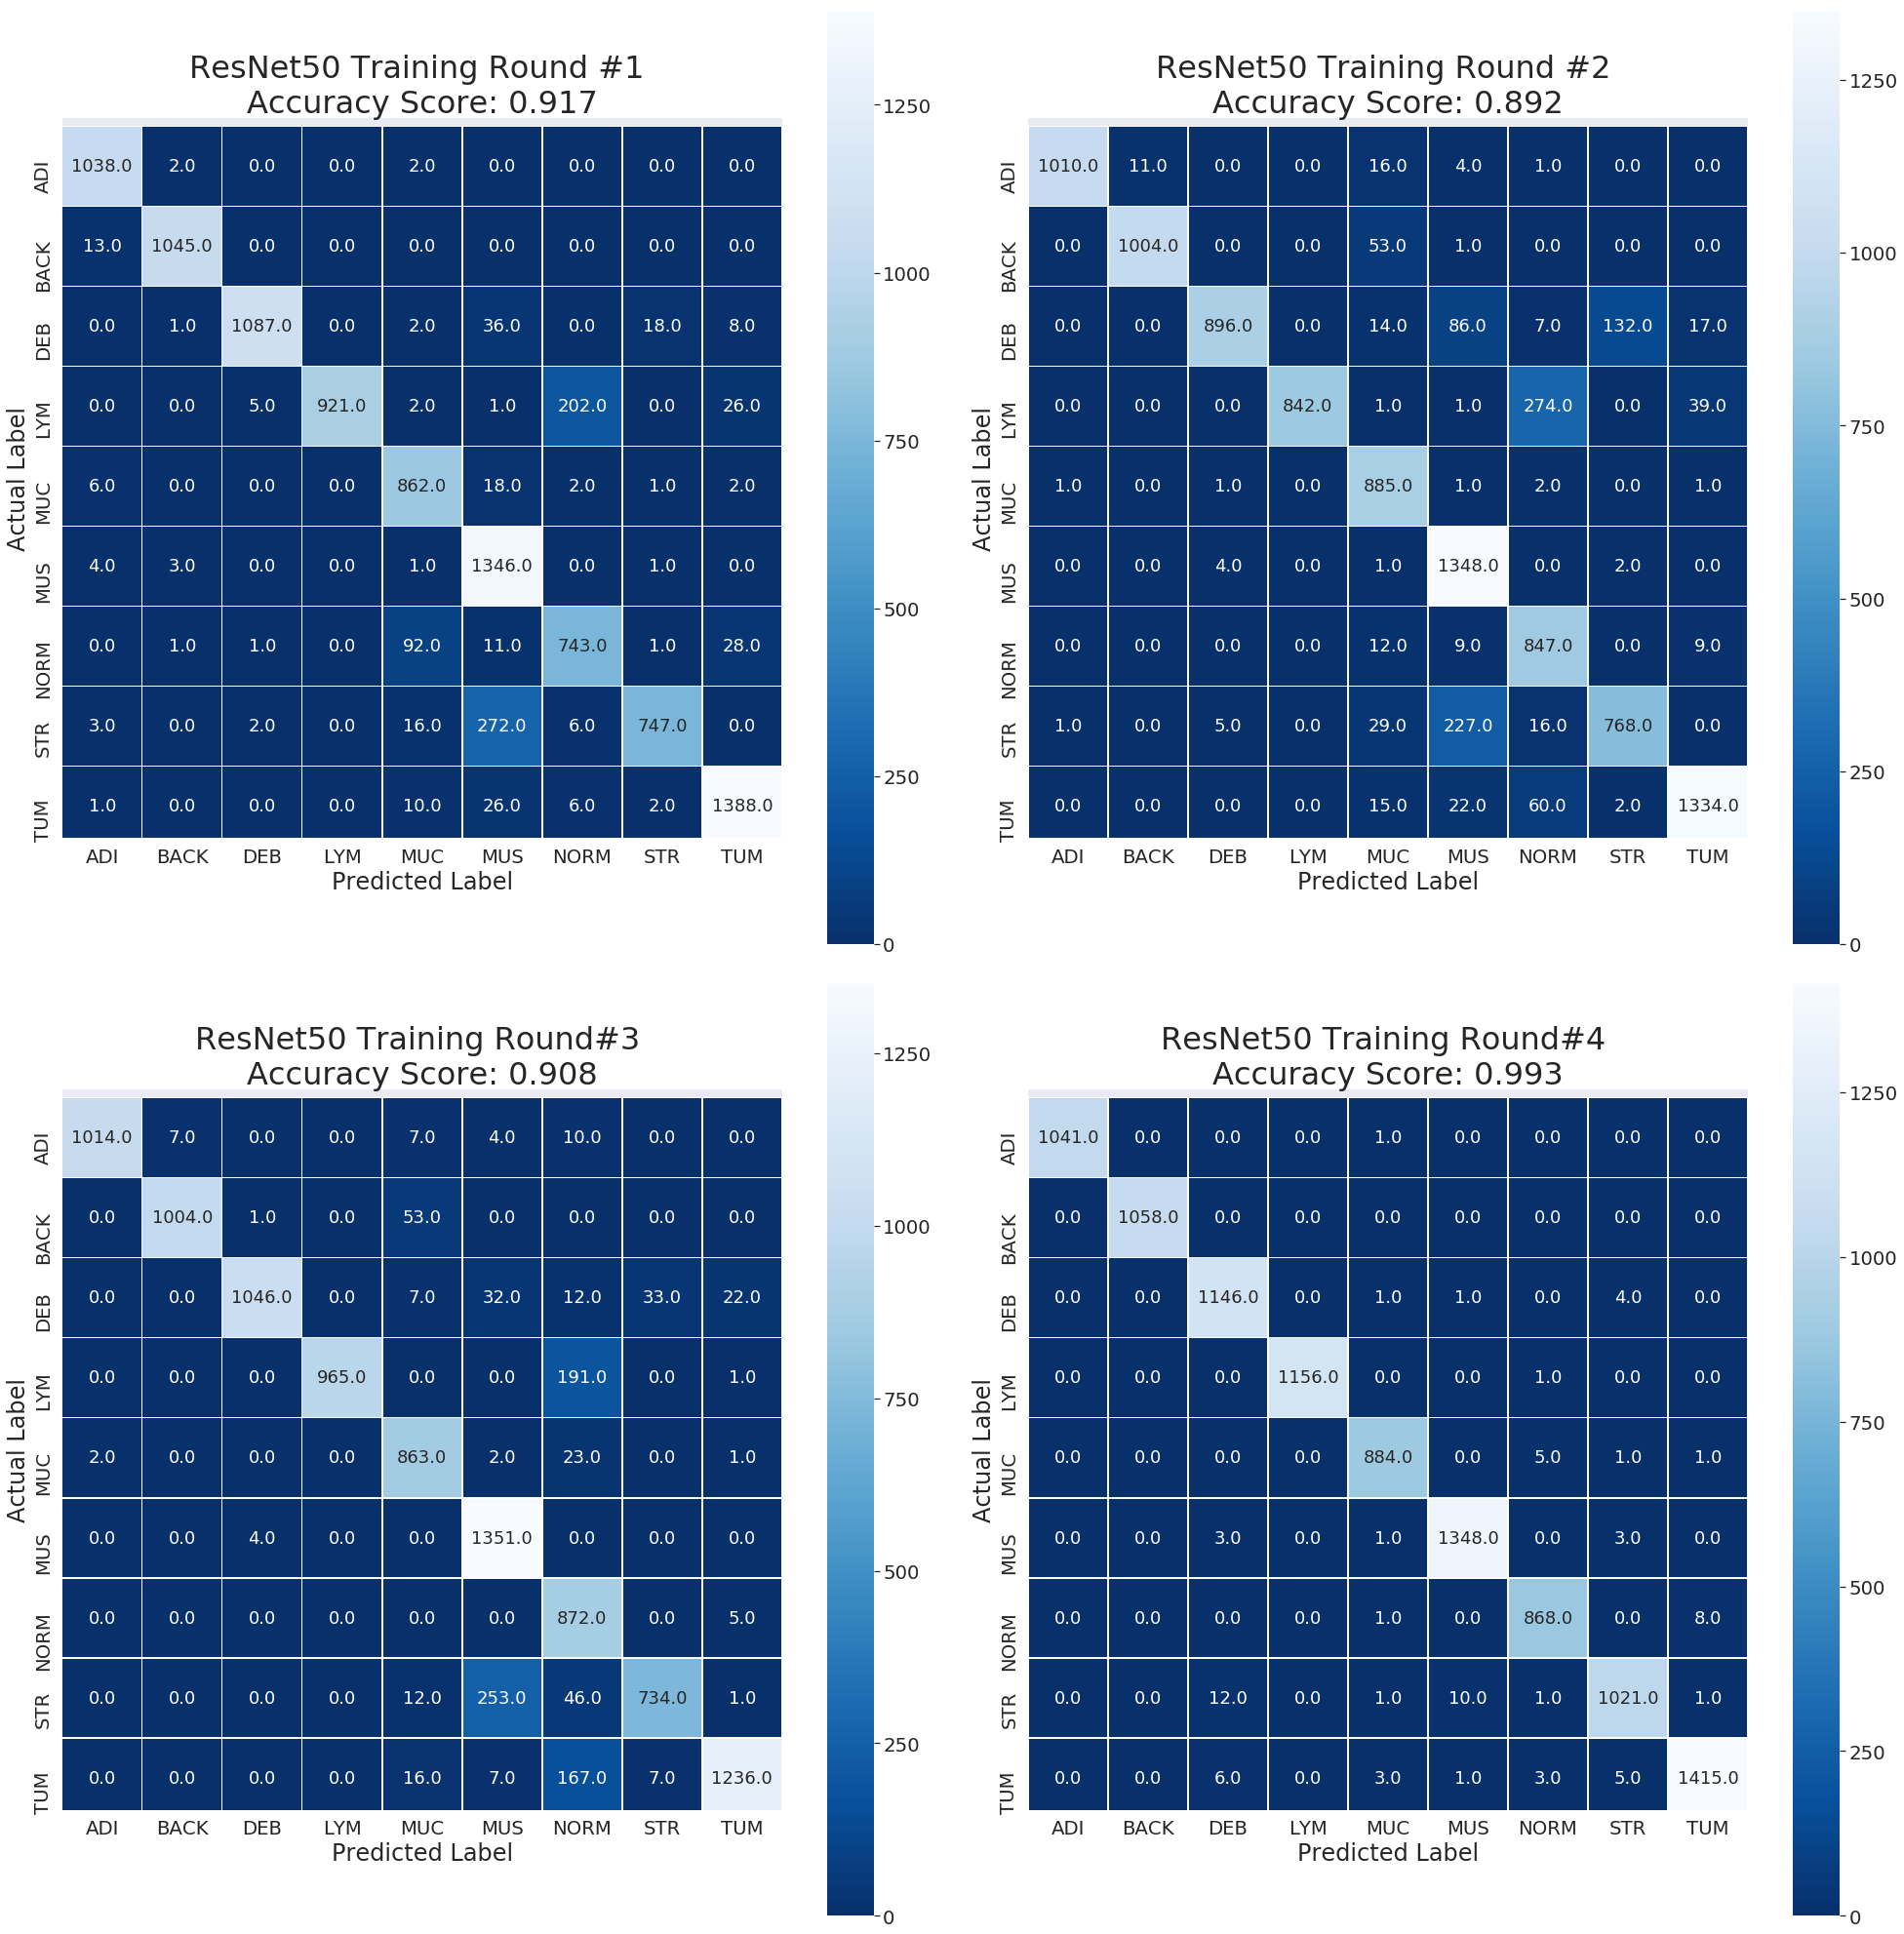

In [54]:
# Plot Confusion Matrices
sns.set(font_scale=1.8)
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(28,28))

#ax1
sns.heatmap(res_conf_mat_01, ax=ax1, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r', annot_kws={"size": 18})
ax1.set_ylabel("Actual Label", fontsize=24)
ax1.set_xlabel("Predicted Label", fontsize=24)
all_sample_title="ResNet50 Training Round #1 \nAccuracy Score: {0:.3f}".format(res_test_eval_01[1])
ax1.set_title(all_sample_title, size=32)
ax1.set_ylim(len(res_conf_mat_01)-0.1, -0.1)

#ax2
sns.heatmap(res_conf_mat_02, ax=ax2, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r', annot_kws={"size": 18})
ax2.set_ylabel("Actual Label", fontsize=24)
ax2.set_xlabel("Predicted Label", fontsize=24)
all_sample_title="ResNet50 Training Round #2 \nAccuracy Score: {0:.3f}".format(res_test_eval_02[1])
ax2.set_title(all_sample_title, size=32)
ax2.set_ylim(len(res_conf_mat_02)-0.1, -0.1)

#ax3
sns.heatmap(res_conf_mat_03, ax=ax3, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r', annot_kws={"size": 18})
ax3.set_ylabel("Actual Label", fontsize=24)
ax3.set_xlabel("Predicted Label", fontsize=24)
all_sample_title="ResNet50 Training Round#3 \nAccuracy Score: {0:.3f}".format(res_test_eval_03[1])
ax3.set_title(all_sample_title, size=32)
ax3.set_ylim(len(res_conf_mat_03)-0.1, -0.1)

#ax4
sns.heatmap(res_conf_mat_04, ax=ax4, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r', annot_kws={"size": 18})
ax4.set_ylabel("Actual Label", fontsize=24)
ax4.set_xlabel("Predicted Label", fontsize=24)
all_sample_title="ResNet50 Training Round#4 \nAccuracy Score: {0:.3f}".format(res_test_eval_04[1])
ax4.set_title(all_sample_title, size=32)
ax4.set_ylim(len(res_conf_mat_04)-0.1, -0.1)


plt.tight_layout()


In [89]:
# Test data
filenames = test_generator.filenames
nb_samples = len(filenames)

class_labels = test_generator.class_indices
class_names = {value:key for key,value in class_labels.items()}

labels = (ind_test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in res_pred_labels_04]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

random_files = results.sample(36)
filenames = random_files['Filename'].tolist()
predicted_labels = random_files['Predictions'].tolist()
test_file_paths = ['/floyd/home/output/test/'+ filename for filename in filenames]

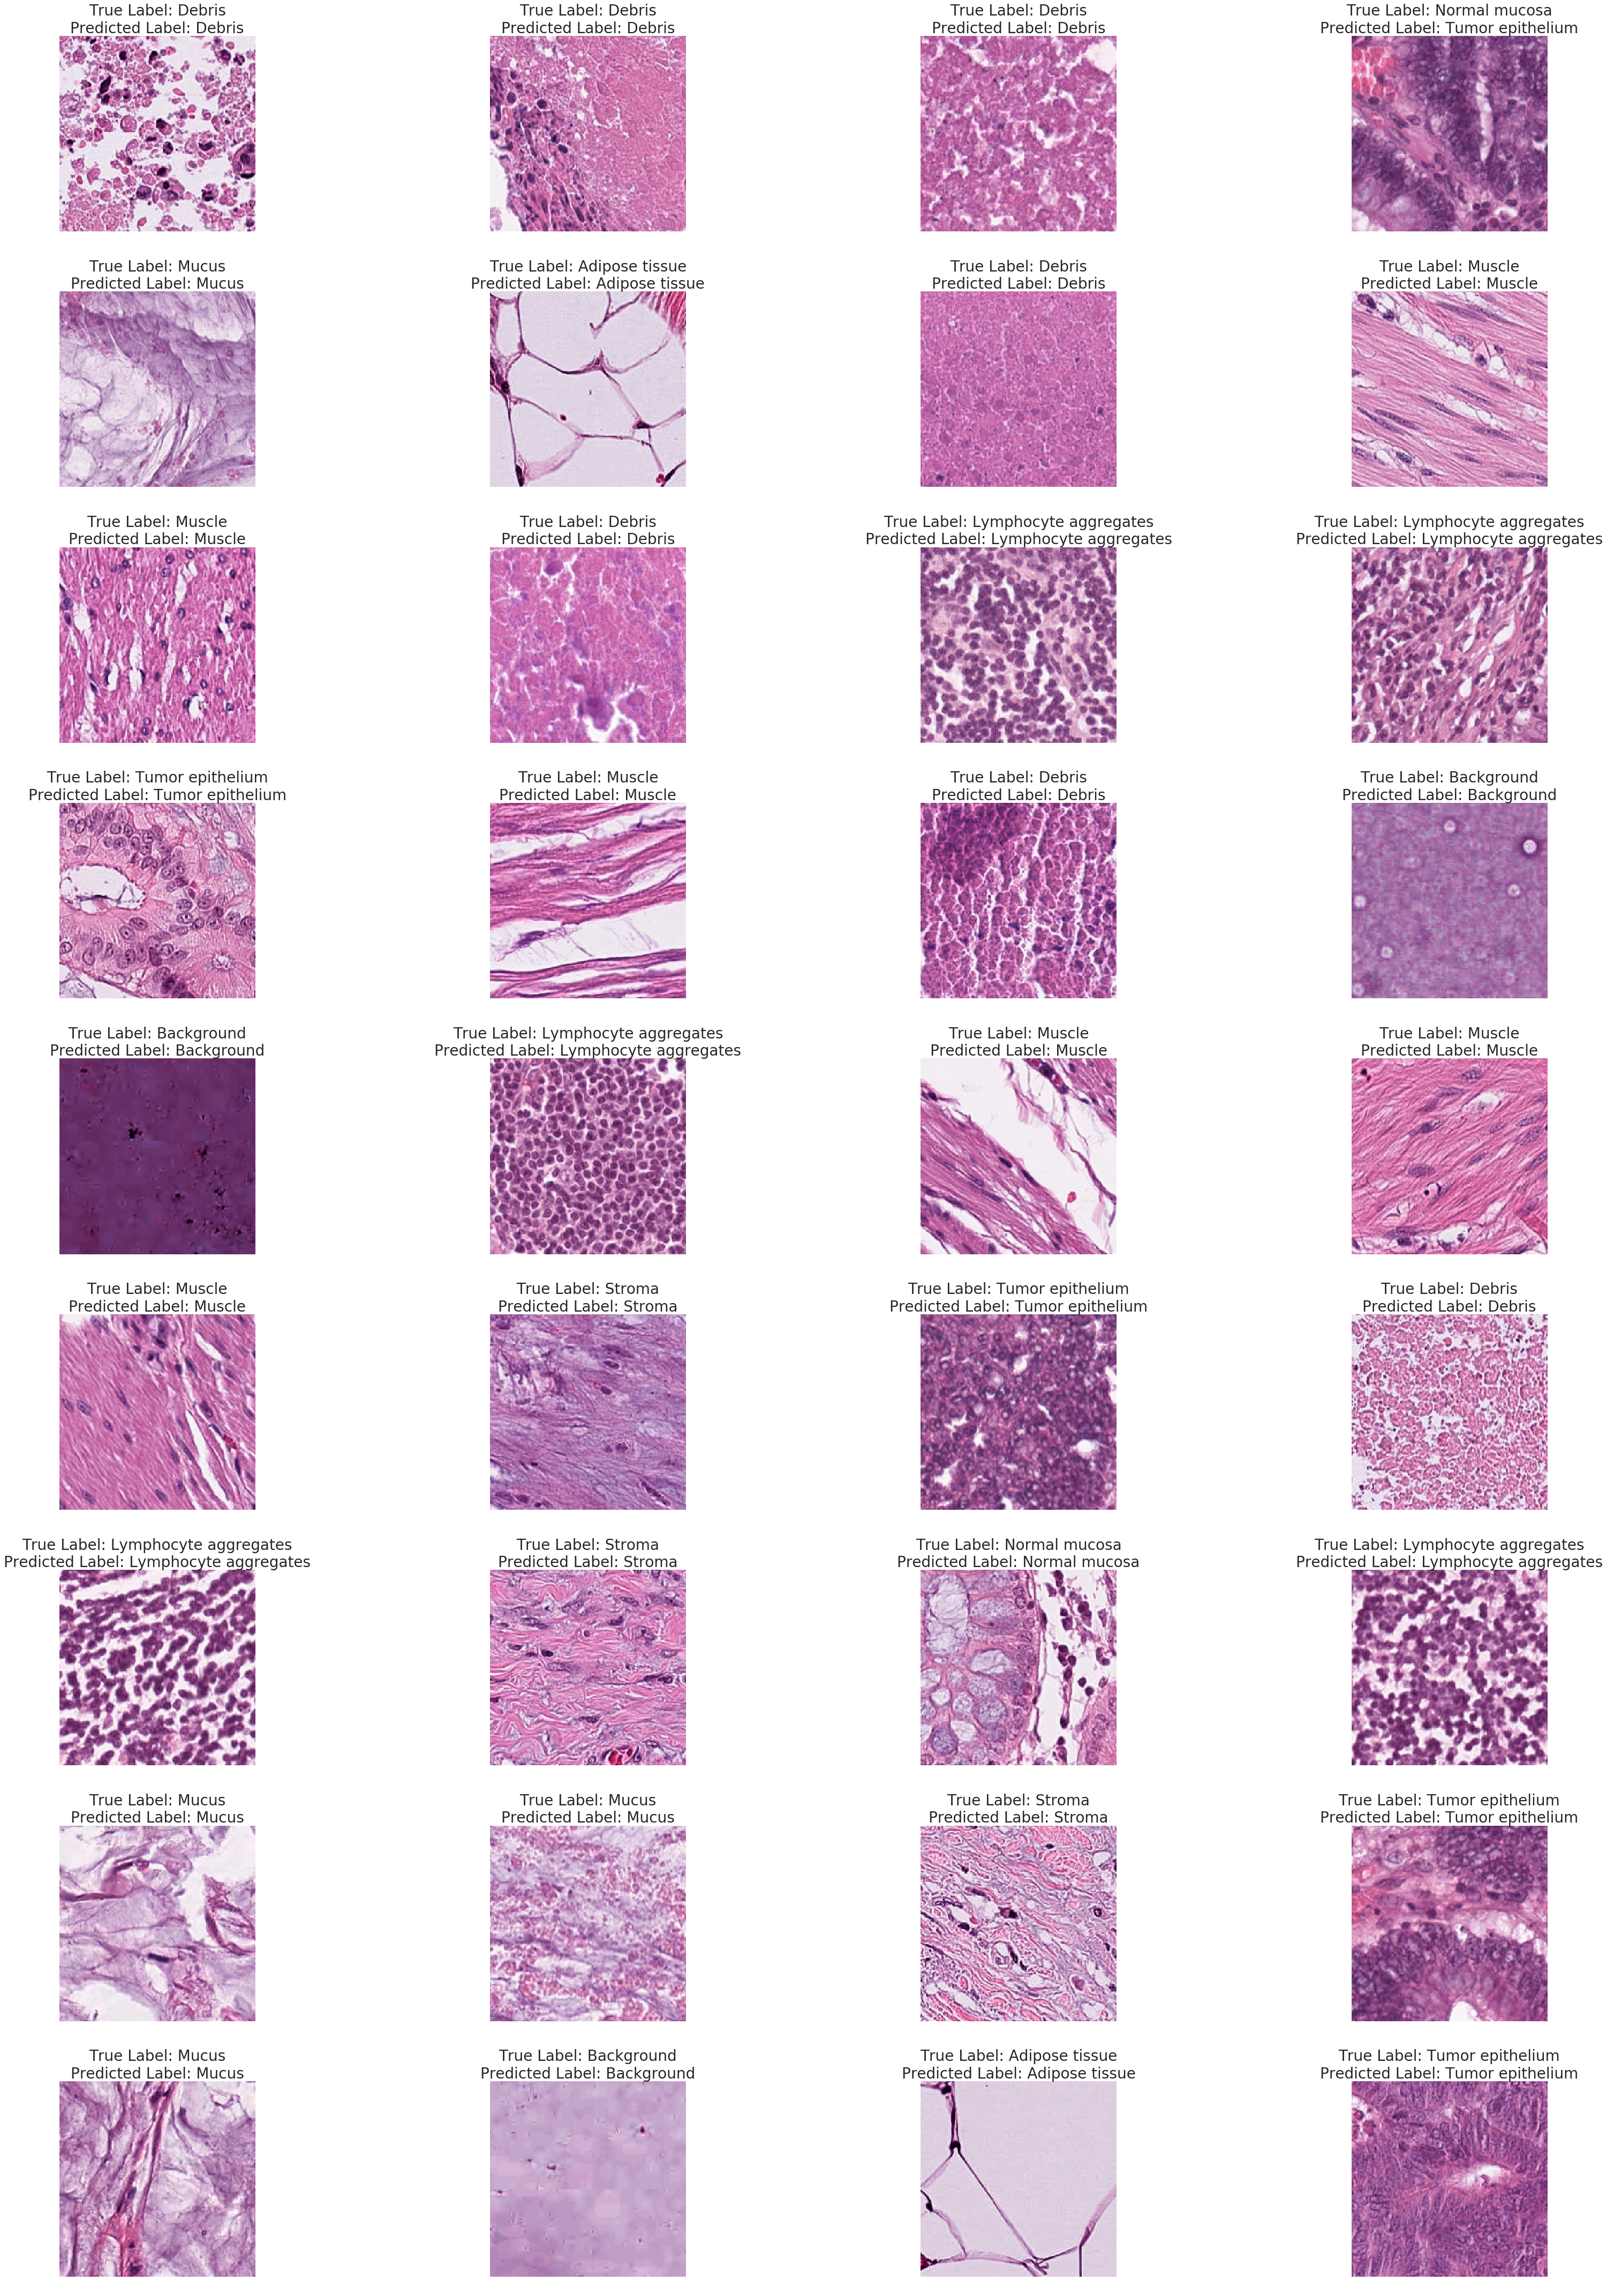

In [87]:
# Tissue types dictionary mapping class names with full names
tissue_types = {"ADI": "Adipose tissue",
               "BACK": "Background",
               "DEB": "Debris",
               "LYM": "Lymphocyte aggregates",
               "MUC": "Mucus", 
               "MUS": "Muscle",
               "NORM": "Normal mucosa", 
               "STR": "Stroma",
               "TUM": "Tumor epithelium"}

fig = plt.figure(figsize=(45,60))
fig.subplots_adjust(top=0.88)
columns = 4
rows = 9

for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(test_file_paths[i-1]))
    plt.axis('off')
    true_label = test_file_paths[i-1].split('/')[-2]
    predicted_label = predicted_labels[i-1]
    plt.title("True Label: {}\nPredicted Label: {}".format(tissue_types[true_label], tissue_types[predicted_label]), fontsize=28)
plt.tight_layout()
    
plt.show()